# Import libraries

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch

import config as CFG
import utils
from Data.calib_loader import CalibDataset
from models.MulCal_v2 import MulCal
from models.spa import SPA

In [2]:
# Fixing random seeds
torch.manual_seed(1368)
rs = np.random.RandomState(1368)

In [3]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

# Load data

In [4]:
# Prepare dataset
X_train, y_train, lab_train, X_val, y_val, lab_val, X_test, y_test, lab_test = utils.prepare_multicalib_dataset(single=False)
X_mean = X_train.mean(axis=0).mean(axis=1)
X_std = X_train.std(axis=0).mean(axis=1)

test_loader = torch.utils.data.DataLoader(CalibDataset(X_test, y_test, lab_test), batch_size=CFG.batch_size, shuffle=False)

# Load model

In [5]:
# Load model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = MulCal(CFG.input_dim, CFG.hidden_dim, CFG.output_dim, CFG.n_class, device, X_mean, X_std, noise=True, new_gen=False)
model.load_state_dict(torch.load(f"./logs/fimicalib/multi_best.pt", map_location=device))
model.to(device)
model.eval()

MulCal(
  (extractor): SeriesEncoder(
    (lstm): LSTM(4, 64)
    (bilstm): LSTM(64, 62, bidirectional=True)
  )
  (identity): IdentityLayer_v2(
    (module): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (seperate_module): IdentityMergingModule(
    (query_tfm): Linear(in_features=64, out_features=128, bias=True)
    (context_lstm): LSTM(640, 640, batch_first=True)
    (score_module): Sequential(
      (0): Linear(in_features=128, out_features=384, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
      (2): Linear(in_features=384, out_features=15, bias=True)
    )
    (tanh): Tanh()
    (softmax): Softmax(dim=-1)
  )
  (calib): IdentityAwaredCalibModule_v2(
    (identity_latent): Linear(in_features=128, out_features=64, bias=True)
    (x_latent): Linear(in_features=128, out_features=64, bias=True)
    (attention_i): Attention(
      (fc): Linear(in_features=64, ou

In [6]:
# Load baseline
spa = SPA(CFG.input_dim, CFG.hidden_dim, CFG.output_dim, CFG.n_class, device, X_mean, X_std)
spa.load_state_dict(torch.load(f"./logs/spa/multi_best.pt", map_location=device))
spa.to(device)
spa.eval()

SPA(
  (pri_enc): Sequential(
    (Pri Enc 0): SeriesEncoder(
      (lstm): LSTM(4, 64)
      (bilstm): LSTM(64, 64, bidirectional=True)
    )
    (Pri Enc 1): SeriesEncoder(
      (lstm): LSTM(4, 64)
      (bilstm): LSTM(64, 64, bidirectional=True)
    )
    (Pri Enc 2): SeriesEncoder(
      (lstm): LSTM(4, 64)
      (bilstm): LSTM(64, 64, bidirectional=True)
    )
    (Pri Enc 3): SeriesEncoder(
      (lstm): LSTM(4, 64)
      (bilstm): LSTM(64, 64, bidirectional=True)
    )
    (Pri Enc 4): SeriesEncoder(
      (lstm): LSTM(4, 64)
      (bilstm): LSTM(64, 64, bidirectional=True)
    )
  )
  (sha_enc): SeriesEncoder(
    (lstm): LSTM(20, 64)
    (bilstm): LSTM(64, 64, bidirectional=True)
  )
  (att): Attention2(
    (linear_in): Linear(in_features=128, out_features=128, bias=False)
    (linear_out): Linear(in_features=256, out_features=128, bias=False)
    (softmax): Softmax(dim=-1)
    (tanh): Tanh()
  )
  (dec): Sequential(
    (DEC 0): Linear(in_features=256, out_features=4, bias=

# Inference function

In [7]:
# Inference function
def infer(model, x, lab, baseline=False):
    noise_batch = torch.tensor(rs.normal(0, 1, (x.size(0), CFG.input_timestep, CFG.noise_dim)), device=device, dtype=torch.float32)
    pred, _ = model(x, lab, noise_batch) if not baseline else model(x, lab)
    return pred

# Inference

In [8]:
x, y, lab = next(iter(test_loader))
x = x.to(device)
lab = lab.to(device)

# Fimicalib
preds = infer(model, x, lab)

# SPA
preds_spa = infer(spa, x, lab, baseline=True)

x = x.detach().cpu()
lab = lab.detach().cpu()
preds = preds.detach().cpu()
preds_spa = preds_spa.detach().cpu()

# Results

In [9]:
# PM2.5 and device 1
print("Results of 10 time steps:")
x_te = x[:10, 0, 0, 0] 
print("Raw: ", x_te)

y_te = y[:10, 0, 0, 0]
print("Ground truth: ", y_te)

pred_te = preds[:10, 0, 0, 0]     
print("Calibration data of Fimicalib: ", pred_te)

pred_te_spa = preds_spa[:10, 0, 0, 0]     
print("Calibration data of SPA: ", pred_te_spa)

Results of 10 time steps:
Raw:  tensor([17.4700, 17.7000, 17.4300, 17.9800, 18.0800, 19.0000, 18.0200, 17.9500,
        18.0800, 18.6800])
Ground truth:  tensor([44., 45., 47., 47., 48., 48., 48., 49., 49., 49.])
Calibration data of Fimicalib:  tensor([49.7698, 50.0493, 50.6740, 50.9813, 51.3581, 51.3867, 51.3556, 51.5774,
        51.7523, 51.7037])
Calibration data of SPA:  tensor([53.3328, 53.6567, 54.4199, 55.2846, 55.8173, 56.2361, 55.7301, 56.3702,
        57.1046, 57.4418])


# Visualization

In [10]:
# Plot
def plot(x, y, preds, mname):
    atts = ['PM2_5', 'PM10']
    ids = ['1', '14', '20', '27', '30']
    fig, ax = plt.subplots(len(atts), len(ids), figsize=(25, 5.5))

    for i, idx in enumerate(ids):                                  
        for j, att in enumerate(atts):                             
            x_i = x[:, i, 0, j]                          
            y_i = y[:, i, 0, j]                          
            pred_i = preds[:, i, 0, j]                             

            rn_test = range(x_i.shape[0])                          
            ax[j, i].plot(rn_test, x_i, 'g', label='raw')          
            ax[j, i].plot(rn_test, y_i, 'b', label='gtruth')       
            ax[j, i].plot(rn_test, pred_i, 'r', label='calibrated')
            ax[j, i].legend(loc='best')
            if j == 0:
                ax[j, i].set_title(f"device: {idx}")  
            if j == len(atts) - 1:
                ax[j, i].set_xlabel("time")
            if i == 0:
                ax[j, i].set_ylabel(att)   
              
    fig.suptitle(f"Calibration results of {mname}", fontsize=20)
    fig.savefig(f"./logs/{mname}_test.pdf")

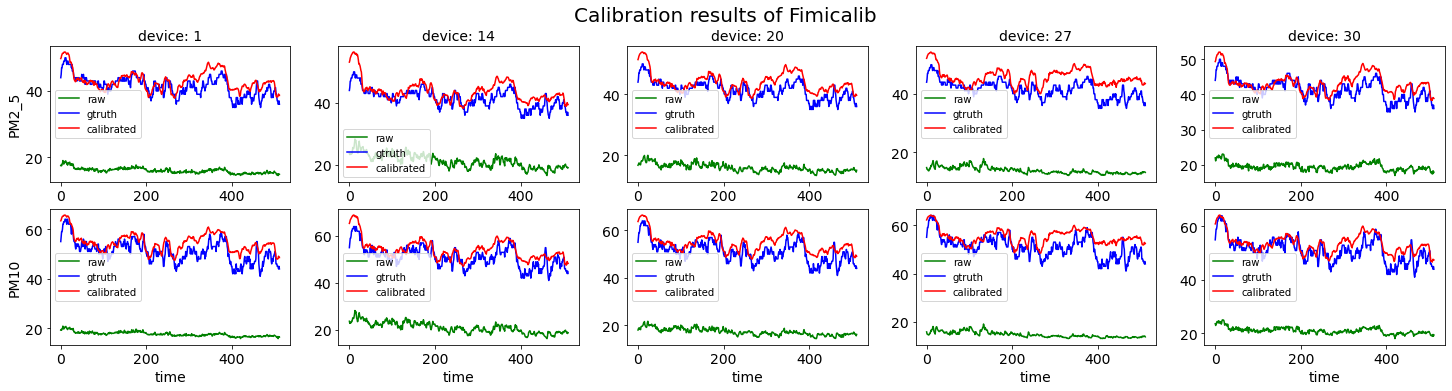

In [11]:
plot(x, y, preds, "Fimicalib")

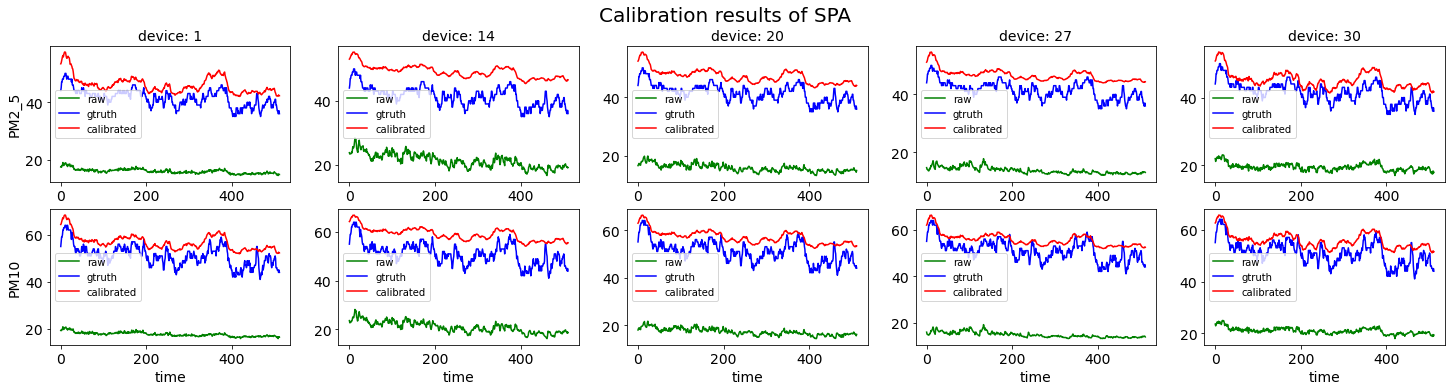

In [12]:
plot(x, y, preds_spa, "SPA")